In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# training CNN using pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
file_name = "/kaggle/input/stead-chunk-2/chunk2.hdf5"
csv_file = "/kaggle/input/stead-chunk-2/chunk2.csv"

df = pd.read_csv(csv_file)
pd.set_option('display.max_columns', 500)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

# Check for missing values
print('Number of missing values:', df.isnull().sum().sum())


Number of rows: 200000
Number of columns: 35
Number of missing values: 79691


In [4]:
print('Number of duplicate rows:', df.duplicated().sum())
df = df.drop_duplicates()

# Handle missing values
print('Number of rows with missing values:', df.isnull().any(axis=1).sum())
df = df.dropna()

Number of duplicate rows: 0
Number of rows with missing values: 73477


In [7]:
num_cols = ['receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
            'p_weight', 'p_travel_sec', 's_arrival_sample', 's_weight', 'source_origin_uncertainty_sec',
            'source_latitude', 'source_longitude', 'source_error_sec', 'source_gap_deg',
            'source_horizontal_uncertainty_km', 'source_depth_km', 'source_depth_uncertainty_km',
            'source_magnitude', 'source_distance_deg', 'source_distance_km', 'back_azimuth_deg',
            'snr_db', 'coda_end_sample']

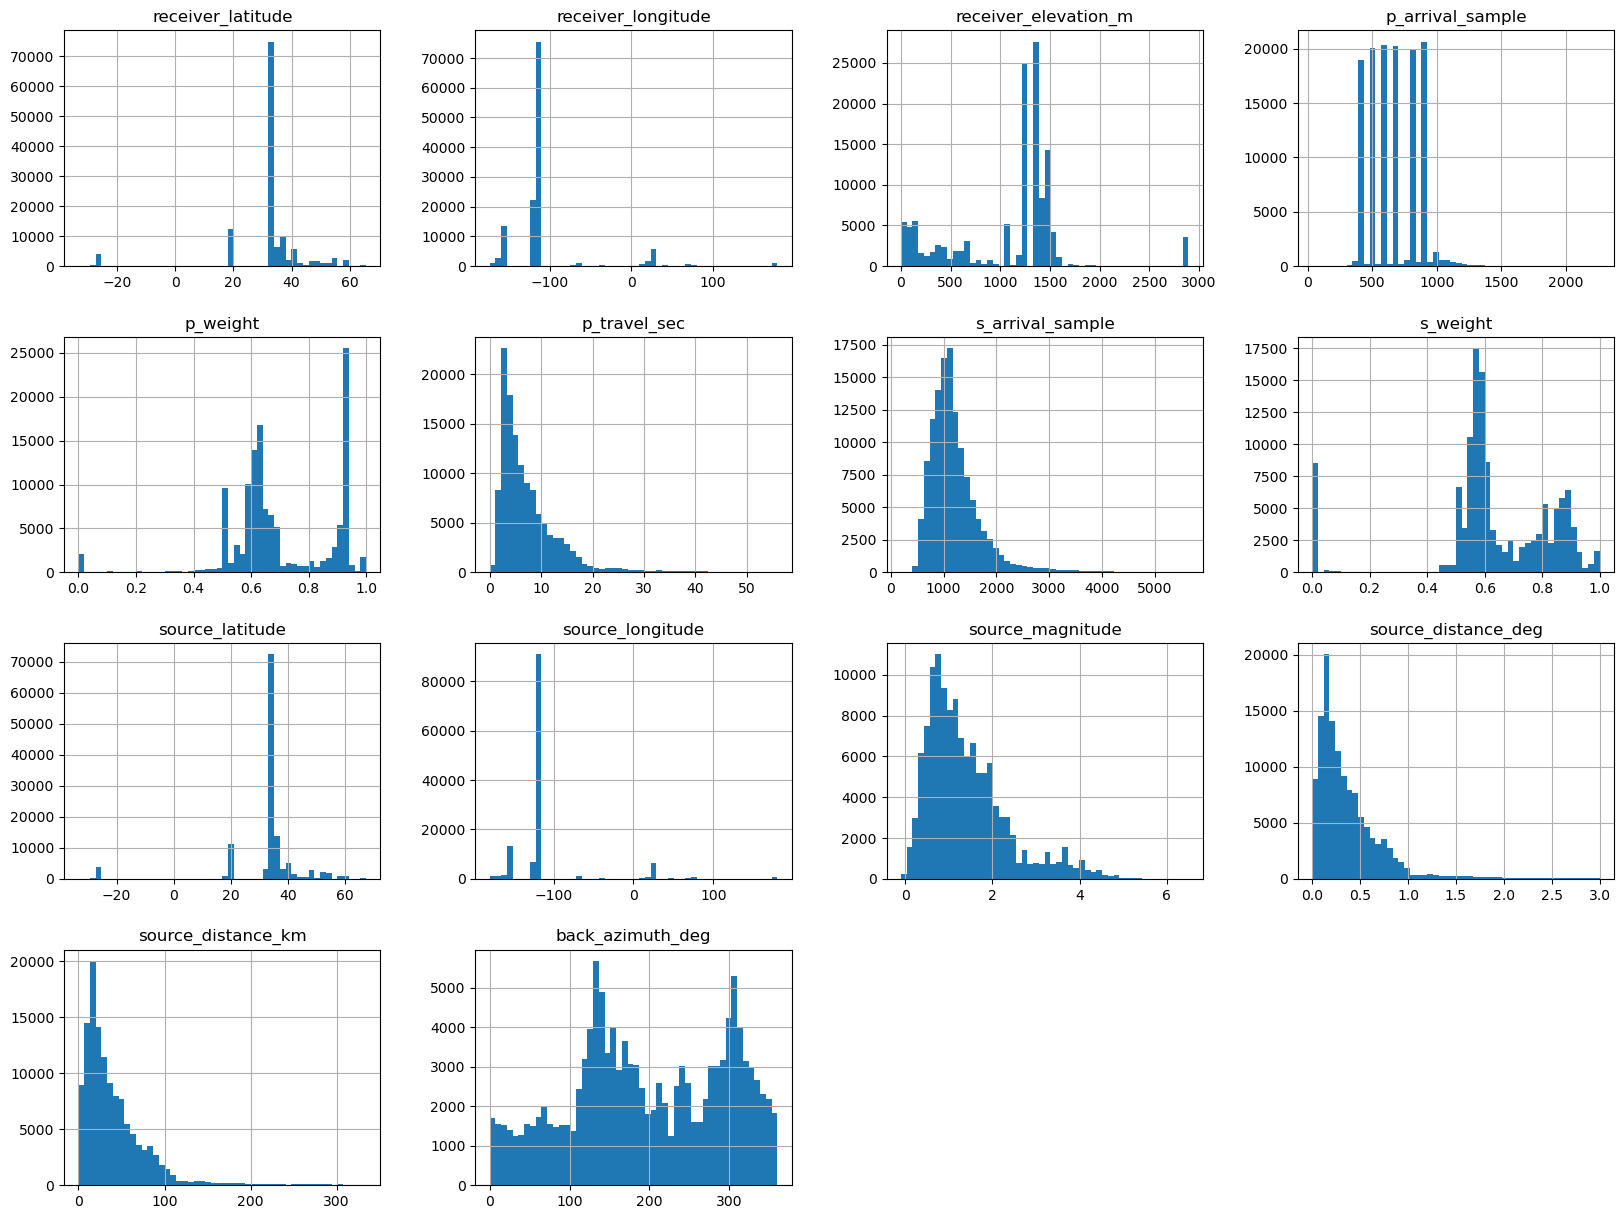

In [8]:
df[num_cols].hist(bins=50, figsize=(20,15))
plt.show()

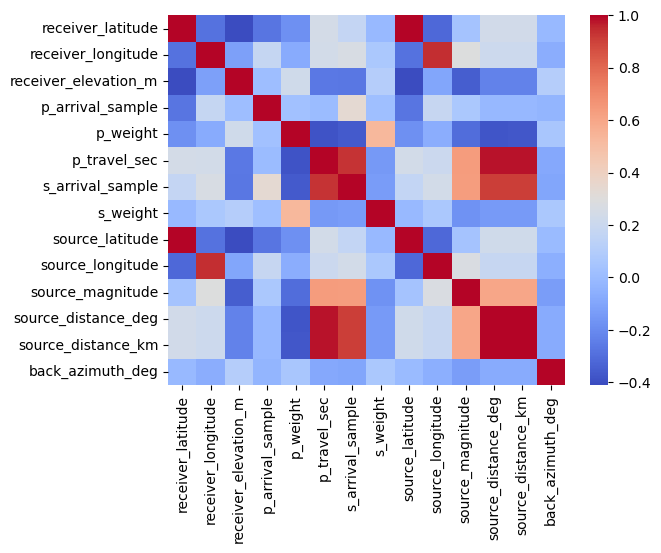

In [9]:
import seaborn as sns
# Check the correlation between numerical columns
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

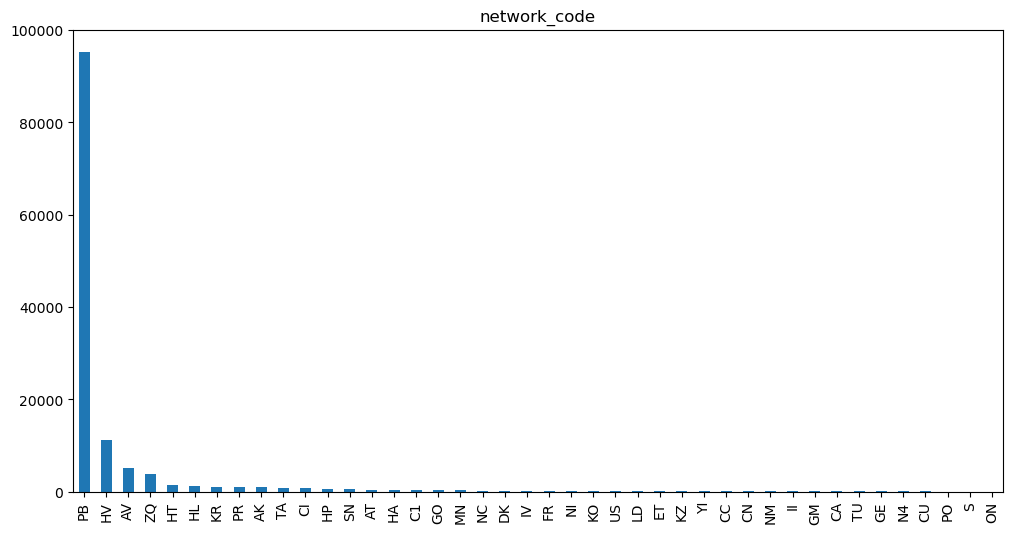

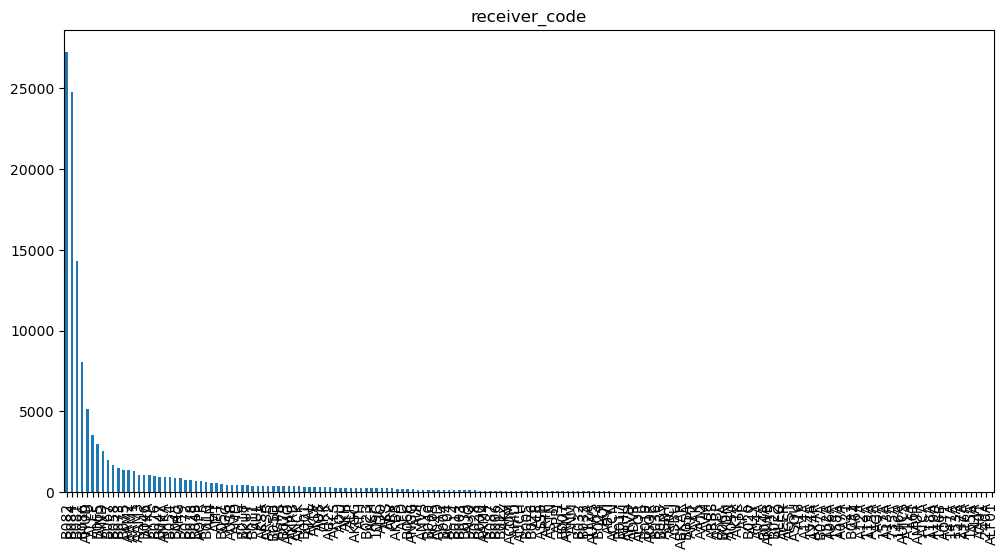

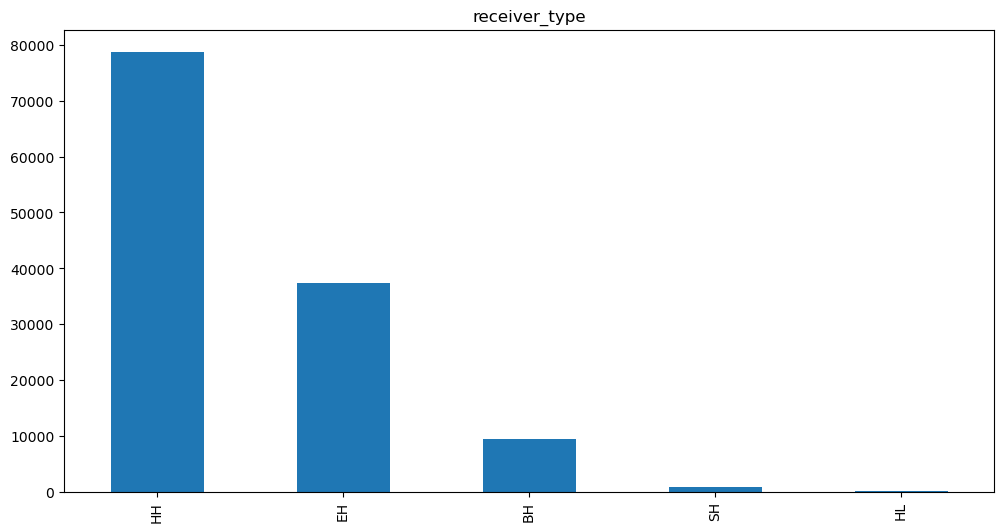

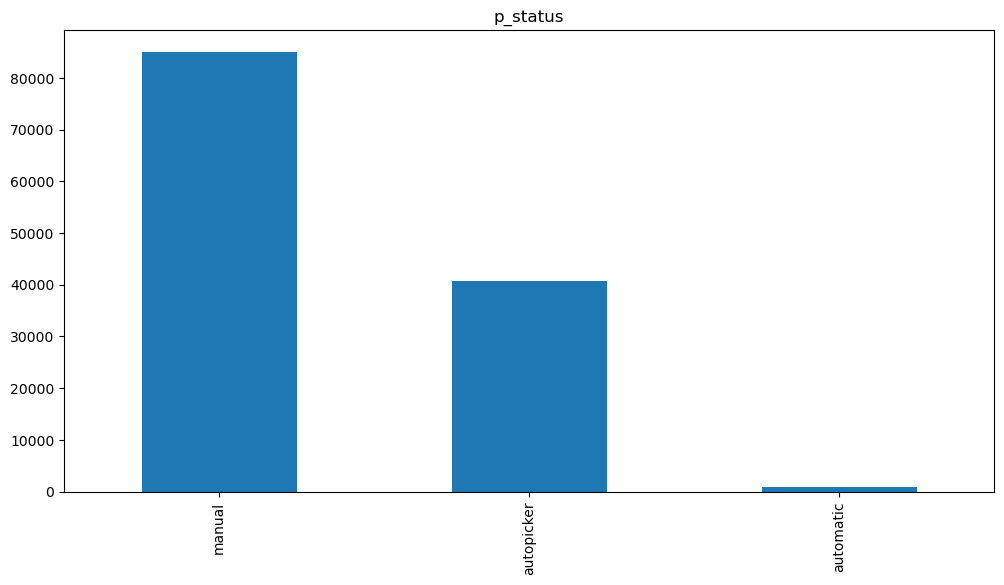

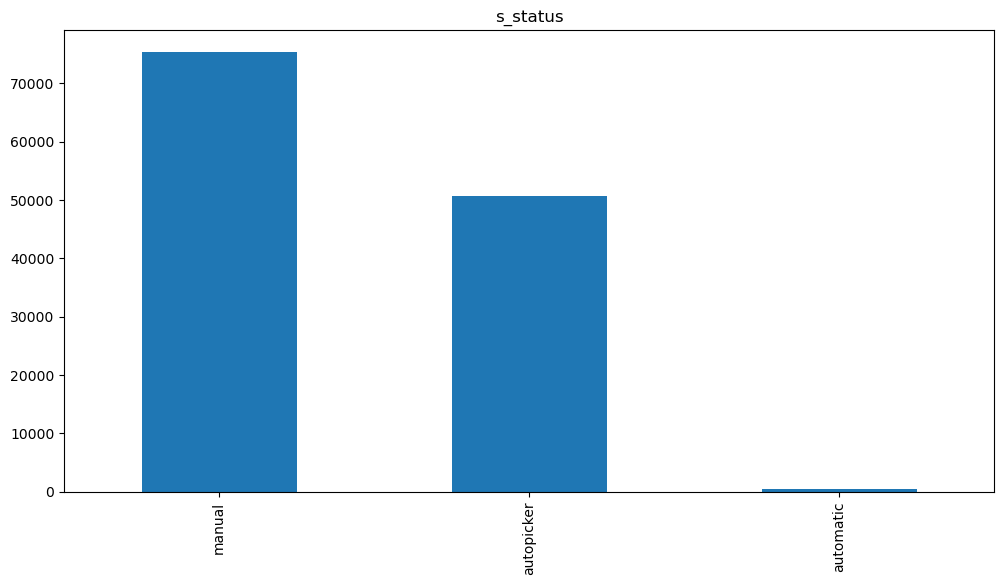

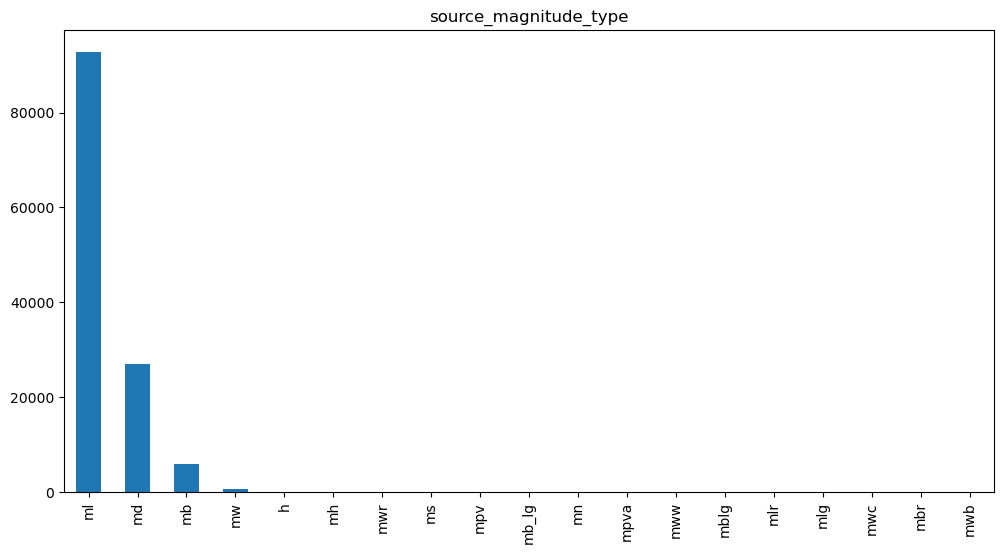

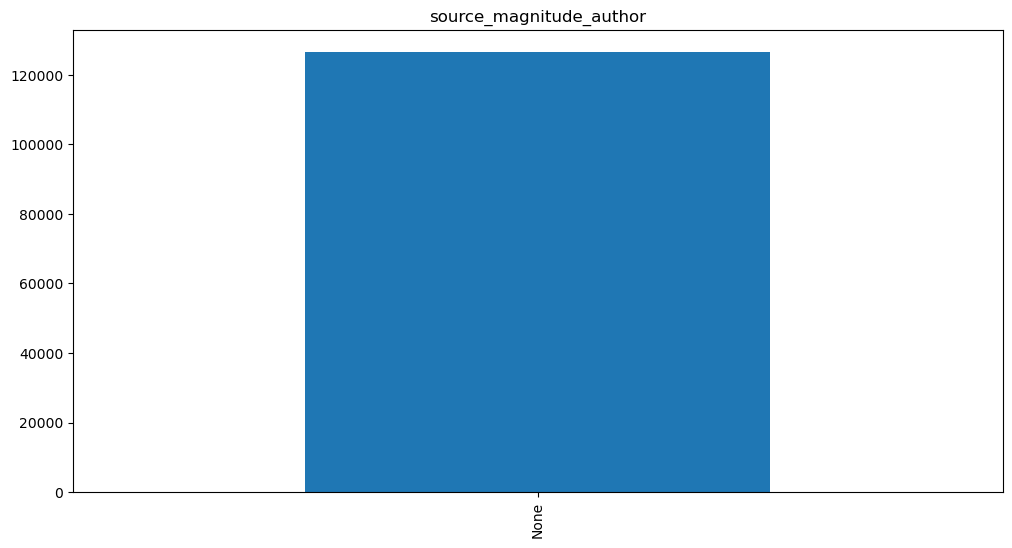

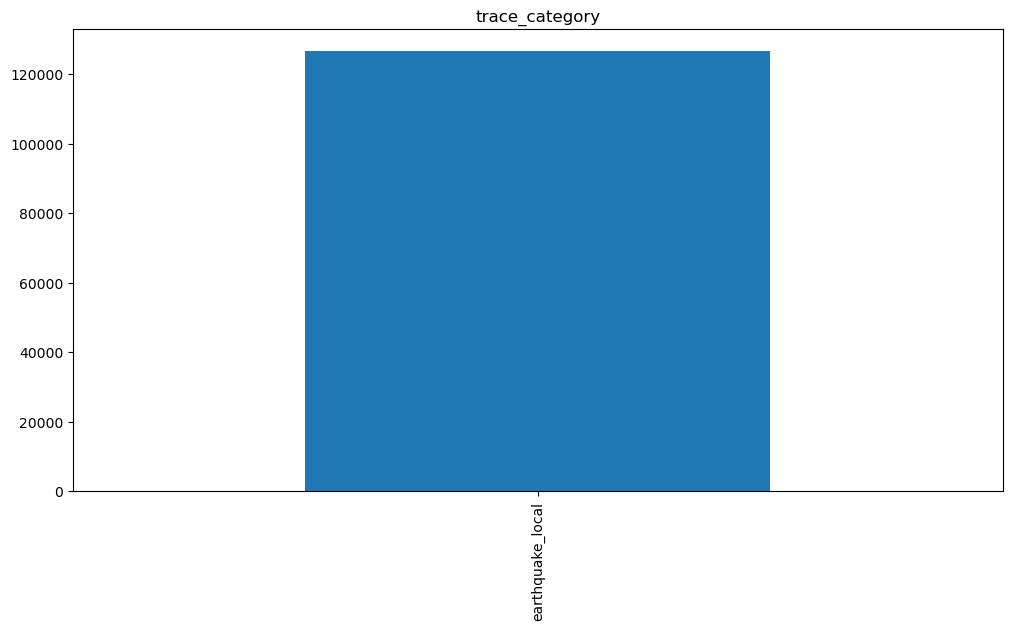

In [10]:
# Check the distribution of categorical columns
cat_cols = ['network_code', 'receiver_code', 'receiver_type', 'p_status', 's_status',
            'source_magnitude_type', 'source_magnitude_author', 'trace_category']
for col in cat_cols:
    plt.figure(figsize=(12,6))
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

In [11]:
# Print the cleaned dataset
print('Cleaned dataset:')
df.head()
print(f"Shape: {df.shape}")

Cleaned dataset:
Shape: (126523, 35)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import cv2

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime
from joblib import Parallel,delayed

from scipy import signal
from scipy.signal import resample,hilbert
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [13]:
def waveform_spectrogram_plot(signal_path,signal_index,signal_list):
    dtfl = h5py.File(signal_path, 'r') # find the signal file
    dataset = dtfl.get('data/'+str(signal_list[signal_index])) # fetch one signal from the file
    # waveforms, 3 channels: first row: E channel, second row: N channel, third row: Z channel
    data = np.array(dataset)

    # plot
    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9,7))
    ax1.plot(np.linspace(0,60,6000),data[:,2],color='k',linewidth=1) # plot waveform
    ymin, ymax = ax1.get_ylim()
    ax1.vlines(dataset.attrs['p_arrival_sample']/100,ymin,ymax,color='b',linewidth=1.5, label='P-arrival') # plot p-wave arrival time
    ax1.vlines(dataset.attrs['s_arrival_sample']/100, ymin, ymax, color='r', linewidth=1.5, label='S-arrival') # plot s-wave arrival time
    ax1.vlines(dataset.attrs['coda_end_sample']/100, ymin, ymax, color='cyan', linewidth=1.5, label='Coda end')
    ax1.set_xlim([0,60])
    ax1.legend(loc='lower right',fontsize=10)
    ax1.set_ylabel('Amplitude (counts)')
    ax1.set_xlabel('Time (s)')
    im = ax2.specgram(data[:,2],Fs=100,NFFT=256,cmap='jet',vmin=-10,vmax=25); # plot spectrogram
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_xlabel('Time (s)')
    ax3.psd(data[:,2],256,100,color='cornflowerblue') # plot power spectral density
    ax3.set_xlim([0,50])
    plt.savefig('waveform_spectrogram_plot.png',dpi=500)
    plt.tight_layout()
    plt.show()

    print('The p-wave for this waveform was picked by: ' + dataset.attrs['p_status'])
    print('The s-wave for this waveform was picked by: ' + dataset.attrs['s_status'])

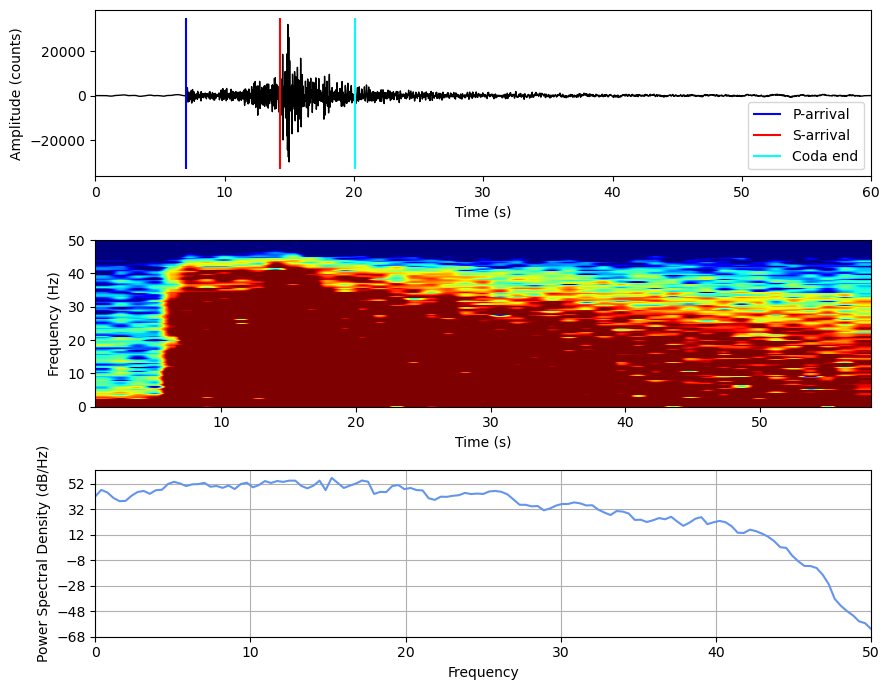

The p-wave for this waveform was picked by: manual
The s-wave for this waveform was picked by: manual


In [14]:
waveform_spectrogram_plot(file_name,12000,df['trace_name'].to_list())

In [46]:
dir = '/kaggle/input/cnn-img/kaggle/working'
full_csv = df 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import cv2

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime
from joblib import Parallel,delayed

from scipy import signal
from scipy.signal import resample,hilbert
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.utils import shuffle

#######################################################################


class SeismicCNN():

    def __init__(self,model_type,target,choose_dataset_size,full_csv,dir):
        self.model_type = model_type
        self.target = target
        self.choose_dataset_size = choose_dataset_size
        self.full_csv = full_csv
        self.dir = dir
        self.traces_array = []
        self.img_dataset = []
        self.labels = []
        self.imgs = []
        self.train_images = []
        self.train_labels = []
        self.test_images = []
        self.test_labels = []
        self.model = []
        self.test_loss = []
        self.test_acc = []
        self.predicted_classes = []
        self.predicted_probs = []
        self.cm = []
        self.epochs = []
        self.history = []

      
        if self.model_type == 'classification':
            # create list of traces in the image datset
            print('Creating seismic trace list')
            for filename in os.listdir(dir): # loop through image directory and get filenames
                if filename.endswith('.png'):
                    self.traces_array.append(filename[0:-4]) # remove the .png from filename

            if choose_dataset_size == 'full':
                # select only the rows in the metadata dataframe which correspond to images
                print('Selecting traces matching images in directory')
                self.img_dataset = self.full_csv.loc[self.full_csv['trace_name'].isin(self.traces_array)] # select rows from the csv that have matching image files
                self.labels = self.img_dataset['trace_category'] # target variable, 'earthquake' or 'noise'
                self.labels = np.array(self.labels.map(lambda x: 1 if x == 'earthquake_local' else 0)) # transform target variable to numerical categories
                print(f'The number of traces in the directory is {len(self.img_dataset)}')
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through images and read them into the imgs array
                    count += 0
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(self.dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    self.imgs.append(img)
                self.imgs = np.array(self.imgs)
                imgs.shape
                
            elif type(choose_dataset_size) == int:
                seismic_dataset = self.full_csv.loc[self.full_csv['trace_name'].isin(self.traces_array)] # get rows of csv dataset that have corresponding images in directory
                choose_seismic_dataset = np.random.choice(np.array(seismic_dataset['trace_name']),choose_dataset_size,replace=False)
                self.img_dataset = seismic_dataset.loc[seismic_dataset['trace_name'].isin(choose_seismic_dataset)] # random choice of images from the directory
                self.labels = self.img_dataset['trace_category'] # target variable, 'earthquake' or 'noise'
                self.labels = np.array(self.labels.map(lambda x: 1 if x == 'earthquake_local' else 0)) # transform target variable to numerical categories
                print(f'The number of traces in the directory is {len(self.img_dataset)}')
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through trace names in filtered dataframe and append images to imgs array
                    count += 1
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(self.dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    self.imgs.append(img)
                self.imgs = np.array(self.imgs)
                self.imgs.shape
                
            else:
                print('Error: please choose either "full" for variable choose_dataset_size to use the full dataset, or provide an integer number of random samples to take from the dataset')
                        
        elif self.model_type == 'regression':
        
            for filename in os.listdir(dir): # loop through every file in the directory and get trace names from the image files
                if filename.endswith('.png'):
                    self.traces_array.append(filename[0:-4]) # remove .png from image file names
            print(f'The number of all traces in the directory including noise is {len(self.traces_array)}')
            local_quakes = self.full_csv[self.full_csv['trace_category'] == 'earthquake_local'] # get only signals corresponding to local earthquakes, not noise
            local_quakes_data = local_quakes.loc[local_quakes['trace_name'].isin(self.traces_array)]
            
            if choose_dataset_size == 'full':
                self.img_dataset = local_quakes.loc[local_quakes['trace_name'].isin(self.traces_array)]
                print(f'The number of all earthquakes in the directory excluding noise is {len(self.img_dataset)}')
                self.labels = self.img_dataset[target] # target variable
                
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through the images dataframe and read in the images with matching trace names
                    count += 1
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    imgs.append(img)
                self.imgs = np.array(imgs)
                
            elif type(choose_dataset_size) == int:
            
                choose_local_quakes = np.random.choice(np.array(local_quakes_data['trace_name']),choose_dataset_size,replace=False)
                self.img_dataset = local_quakes_data.loc[local_quakes_data['trace_name'].isin(choose_local_quakes)]
                self.labels = self.img_dataset[self.target] # target variable
                
                count = 0
                for i in range(0,len(self.img_dataset['trace_name'])): # loop through dataframe and read in images corresponding to trace names in data frame
                    count += 1
                    #print(f'Working on trace # {count}')
                    img= cv2.imread(dir+'/'+self.img_dataset['trace_name'].iloc[i]+'.png',0) # read in image as grayscale image
                    self.imgs.append(img)
                self.imgs = np.array(self.imgs)
                
            else:
                print('Error: please choose either "full" for variable choose_dataset_size to use the full dataset, or provide an integer number of random samples to take from the dataset')
                
        else:
            print('Error: please choose either "classification" or "regression" for CNN model type')
 

    def train_test_split(self,test_size,random_state):
        # train test split on images, 75% training data and 25% testing data
        # check for high acc 
        self.imgs, self.labels = shuffle(self.imgs, self.labels, random_state=42)
        self.train_images, self.test_images, self.train_labels, self.test_labels = train_test_split(self.imgs,self.labels,random_state=random_state,test_size=test_size, shuffle=True,stratify=self.labels)
        print(f'The training images set is size: {self.train_images.shape}')
        print(f'The training labels set is size: {self.train_labels.shape}')
        print(f'The testing images set is size: {self.test_images.shape}')
        print(f'The testing labels set is size: {self.test_labels.shape}')
        
        print('Scaling image intensity')
        self.train_images = self.train_images/255.0 # scale intensity to between 0 and 1
        self.test_images = self.test_images/255.0 # scale intensity to between 0 and 1

        img_height = self.train_images.shape[1] # get height of each image in pixels
        img_width = self.train_images.shape[2] # get width of each image in pixels

        print('Resizing images')
        self.train_images = self.train_images.reshape(-1,img_height,img_width,1) # reshape to input into CNN which requires a 4-tensor
        self.test_images = self.test_images.reshape(-1,img_height,img_width,1) # reshape to input into CNN which requires a 4-tensor

    def classification_cnn(self,epochs):
        self.epochs = epochs
        
        # set callbacks so that the model will be saved after each epoch
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}',
                save_freq='epoch')
        ]

        # build CNN on dataset
        print('Building CNN model')
        
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(32, kernel_size=(5, 5), activation = 'relu', padding = 'same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Flatten(input_shape=(self.imgs.shape[1],self.imgs.shape[2])))
        model.add(keras.layers.Dense(64,activation='relu'))
        model.add(keras.layers.Dense(16,activation='relu'))
        model.add(keras.layers.Dense(2,activation='softmax'))

        opt = keras.optimizers.Adam(learning_rate=1e-6)
        model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')
        self.history = model.fit(self.train_images,self.train_labels,batch_size=4,epochs=epochs,callbacks=callbacks,validation_split=0.2,shuffle=True)

        print(model.summary())
        
        # Set model save path
        saved_model_path = f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}'
        # Save entire model to a HDF5 file
        model.save(saved_model_path)
        
        self.model = model
        
    def regression_cnn(self,target,epochs):
        self.epochs = epochs
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}',
                save_freq='epoch')
        ]

        # build CNN on dataset
        print('Building Regression CNN model')
        model = keras.Sequential()
        model.add(keras.layers.Conv2D(64, kernel_size=(5, 5), activation = 'relu', padding = 'same'))
        model.add(keras.layers.MaxPool2D(2,2))
        model.add(keras.layers.Dropout(0.50))
        model.add(keras.layers.Flatten(input_shape=(self.imgs.shape[1],self.imgs.shape[2])))
        model.add(keras.layers.Dense(16,activation='relu'))
        model.add(keras.layers.Dense(1))
        
        opt = keras.optimizers.Adam(learning_rate=1e-5)
        model.compile(optimizer=opt,loss='mse',metrics='accuracy')
        self.history = model.fit(self.train_images,self.train_labels,epochs=epochs,callbacks=callbacks,validation_split=0.2,batch_size=4,shuffle=True)

        print(model.summary())
        
        # Set model save path
        saved_model_path = f'./saved_models/specs_{str(self.choose_dataset_size)}dataset_{self.model_type}_{self.target}_epochs{self.epochs}_{format(datetime.now().strftime("%Y%m%d"))}' # _%H%M%S
        # Save entire model to a HDF5 file
        model.save(saved_model_path)
        
        self.model = model


    def evaluate_classification_model(self):
        print('Evaluating model on test dataset')
        self.test_loss, self.test_acc = self.model.evaluate(self.test_images, self.test_labels, verbose=1) # get model evaluation metrics
        print("\nTest data, accuracy: {:5.2f}%".format(100*self.test_acc))

        print('Finding predicted classes and probabilities to build confusion matrix')
        self.predicted_classes = np.argmax(self.model.predict(self.test_images),axis=-1) # predict the class of each image
        self.predicted_probs = self.model.predict(self.test_images) # predict the probability of each image belonging to a class

        # create confusion matrix
        print('Building confusion matrix')
        self.cm = confusion_matrix(self.test_labels,self.predicted_classes) # compare target values to predicted values and show confusion matrix
        print(self.cm)
        accuracy = accuracy_score(self.test_labels,self.predicted_classes)
        precision = precision_score(self.test_labels,self.predicted_classes)
        recall = recall_score(self.test_labels,self.predicted_classes)
        print(f'The accuracy of the model is {accuracy}, the precision is {precision}, and the recall is {recall}.')

        # plot confusion matrix
#         plt.style.use('default')
#         disp = ConfusionMatrixDisplay(confusion_matrix=self.cm, display_labels=['not earthquake','earthquake'])
#         disp.plot(cmap='Blues', values_format='')
#         plt.title(f'Classification CNN Results ({self.epochs} epochs)')
#         plt.tight_layout()
#         plt.savefig('confusion_matrix.png')
#         plt.show()
        
        # plot accuracy history
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['accuracy'])
        ax.plot(self.history.history['val_accuracy'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_accuracy.png')
        plt.show()
        
        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['loss'])
        ax.plot(self.history.history['val_loss'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_loss.png')
        plt.show()
        
    def evaluate_regression_model(self):
        print('Evaluating model on test dataset')
        self.test_loss = self.model.evaluate(self.test_images, self.test_labels, verbose=1)
        print(f'Test data loss: {self.test_loss}')
        
        print('Getting predictions')
        self.predicted = self.model.predict(self.test_images)

        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(7,7))
        ax.scatter(self.test_labels,self.predicted,alpha=0.25)
        point1 = [0,0]
        point2 = [6,6]
        xvalues = [point1[0], point2[0]]
        yvalues = [point1[1], point2[1]]
        ax.plot(xvalues,yvalues,color='blue')
        ax.set_ylabel('Predicted Value',fontsize=14)
        ax.set_xlabel('Observed Value',fontsize=14)
        ax.set_title(f'Regression CNN Results 100k dataset | ({self.epochs} epochs)')
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        plt.tight_layout()
        plt.savefig('true_vs_predicted.png')
        plt.show()

        fig, ax = plt.subplots(figsize=(7,7))
        ax.plot(self.history.history['loss'])
        ax.plot(self.history.history['val_loss'])
        ax.set_title('Model Accuracy')
        ax.set_ylabel('Loss (MSE)')
        ax.set_xlabel('Epoch')
        ax.legend(['train','test'])
        plt.savefig('model_loss.png')
        plt.show()




In [ ]:
# Using the class for a classification CNN
model_cnn_c1 = SeismicCNN('classification','trace_category',200,full_csv,dir) # initialize the class
model_cnn_c1.train_test_split(test_size=0.25,random_state=42) # train_test_split
model_cnn_c1.classification_cnn(10) # use the regression cnn method with 15 epochs with a target variable
model_cnn_c1.evaluate_classification_model() # evaluate the model

Creating seismic trace list
The number of traces in the directory is 200
The training images set is size: (150, 100, 150)
The training labels set is size: (150,)
The testing images set is size: (50, 100, 150)
The testing labels set is size: (50,)
Scaling image intensity
Resizing images
Building CNN model
Epoch 1/10


2023-04-30 04:27:38.814613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/30 [====================>.........] - ETA: 0s - loss: 0.6066 - accuracy: 0.9286

In [27]:
# run the model using CNN regression to predict the earthquake magnitude
model_cnn_rm = SeismicCNN('regression','source_magnitude',1200,full_csv,dir); # initialize the class
model_cnn_rm.train_test_split(test_size=0.4,random_state=42) # train_test_split
model_cnn_rm.regression_cnn('source_magnitude',10) # use the classification cnn method with 15 epochs
model_cnn_rm.evaluate_regression_model() # evaluate the model

The number of all traces in the directory including noise is 126500


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

The number of all traces in the directory including noise is 126500
The training images set is size: (9000, 100, 150)
The training labels set is size: (9000,)
The testing images set is size: (3000, 100, 150)
The testing labels set is size: (3000,)
Scaling image intensity
Resizing images
Building Regression CNN model
Epoch 1/20


2023-04-30 01:13:30.351766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1800/1800 [==============================] - 11s 6ms/step - loss: 230306.2031 - val_loss: 97994.9219
Epoch 2/20
1800/1800 [==============================] - 10s 6ms/step - loss: 83785.5078 - val_loss: 68795.1250
Epoch 3/20
1800/1800 [==============================] - 10s 6ms/step - loss: 59758.5352 - val_loss: 50530.9688
Epoch 4/20
1800/1800 [==============================] - 10s 6ms/step - loss: 44546.3984 - val_loss: 38953.3828
Epoch 5/20
1800/1800 [==============================] - 10s 6ms/step - loss: 35200.2305 - val_loss: 31904.2227
Epoch 6/20
1800/1800 [==============================] - 11s 6ms/step - loss: 29393.5254 - val_loss: 27273.9727
Epoch 7/20
1800/1800 [==============================] - 10s 6ms/step - loss: 25301.2109 - val_loss: 23663.4453
Epoch 8/20
1800/1800 [==============================] - 10s 6ms/step - loss: 21844.8027 - val_loss: 20285.6035
Epoch 9/20
1800/1800 [==============================] - 11s 6ms/step - loss: 18715.7246 - val_loss: 17448.4160
Epoch 10/20

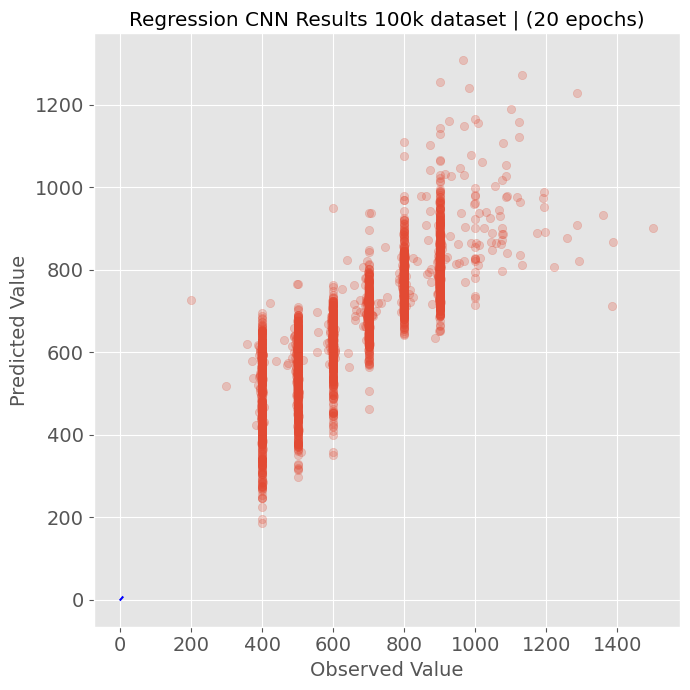

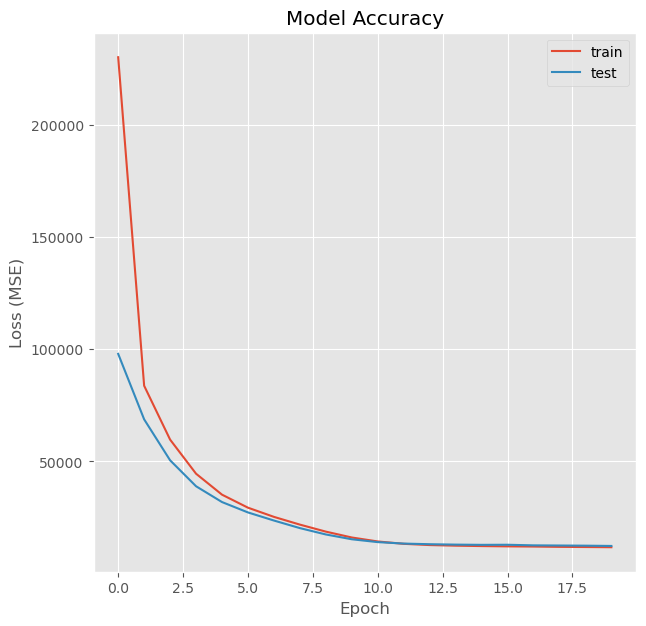

In [18]:
# run the model using CNN regression to predict the p-wave arrival time
model_cnn_rp = SeismicCNN('regression','p_arrival_sample',12000,full_csv,dir); # initialize the class
model_cnn_rp.train_test_split(test_size=0.25,random_state=42) # train_test_split
model_cnn_rp.regression_cnn('p_arrival_sample',20) # use the classification cnn method with 15 epochs
model_cnn_rp.evaluate_regression_model() # evaluate the model


In [ ]:
# run the model using CNN regression to predict the s-wave arrival time
model_cnn_rs = SeismicCNN('regression','s_arrival_sample',12000,full_csv,dir); # initialize the class
model_cnn_rs.train_test_split(test_size=0.25,random_state=42) # train_test_split
model_cnn_rs.regression_cnn('s_arrival_sample',20) # use the classification cnn method with 15 epochs
model_cnn_rs.evaluate_regression_model() # evaluate the model

The number of all traces in the directory including noise is 126500
The training images set is size: (9000, 100, 150)
The training labels set is size: (9000,)
The testing images set is size: (3000, 100, 150)
The testing labels set is size: (3000,)
Scaling image intensity


Creating seismic trace list
The number of traces in the directory is 12000
The training images set is size: (9000, 100, 150)
The training labels set is size: (9000,)
The testing images set is size: (3000, 100, 150)
The testing labels set is size: (3000,)
Scaling image intensity
Resizing images
Building CNN model
Epoch 1/20


2023-04-30 01:18:35.753697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1800/1800 [==============================] - 18s 9ms/step - loss: 0.1034 - accuracy: 0.9942 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 2/20
1800/1800 [==============================] - 11s 6ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 3/20
1800/1800 [==============================] - 12s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 6.4431e-04 - val_accuracy: 1.0000
Epoch 4/20
1800/1800 [==============================] - 11s 6ms/step - loss: 4.0370e-04 - accuracy: 1.0000 - val_loss: 2.1243e-04 - val_accuracy: 1.0000
Epoch 5/20
1800/1800 [==============================] - 11s 6ms/step - loss: 1.3686e-04 - accuracy: 1.0000 - val_loss: 7.3443e-05 - val_accuracy: 1.0000
Epoch 6/20
1800/1800 [==============================] - 11s 6ms/step - loss: 4.8965e-05 - accuracy: 1.0000 - val_loss: 2.6897e-05 - val_accuracy: 1.0000
Epoch 7/20
1800/1800 [==============================] - 11s 6ms/step - loss: 1.8167e-05 - accuracy: 1.0000 - val_

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

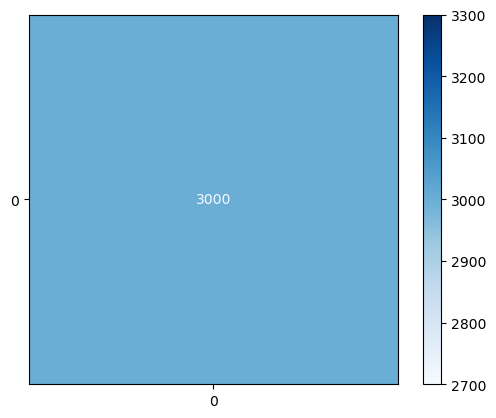

In [19]:
# Using the class for a classification CNN
model_cnn_c1 = SeismicCNN('classification','trace_category',12000,full_csv,dir) # initialize the class
model_cnn_c1.train_test_split(test_size=0.25,random_state=42) # train_test_split
model_cnn_c1.classification_cnn(20) # use the regression cnn method with 15 epochs with a target variable
model_cnn_c1.evaluate_classification_model() # evaluate the model